# BME-230B Spring 2019 HW 2 Question 
James Casaletto, Andrew Davidson, Yuanqing Xue, Jim Zheng

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [GSEAPY: Gene Set Enrichment Analysis in Python. pypi.org](https://pypi.org/project/gseapy/)
    * [GSEAPY: Gene Set Enrichment Analysis in Python gseapy.readthedocs.io](https://gseapy.readthedocs.io/en/latest/introduction.html)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations
    * [Hypergeometric_distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
    * [Hypergeometric Tests
for Gene Lists](http://users.unimi.it/marray/2007/material/day4/Lecture7.pdf)

In [1]:
from euclid_knn import KnnG
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

import scipy.special
import scipy.stats as stats

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")

# run our implementation of nearest neighboors and update anndata
KnnG(anndata, n_neighbors=12, runPCA=True, nPC=50)

CPU times: user 3min 44s, sys: 1.67 s, total: 3min 46s
Wall time: 3min 38s


In [3]:
%%time
# running Scanpy's version of Louvian
# TODO: replace with our implementation
scanpy.tl.louvain(anndata,
                  flavor='igraph', 
                  directed=False, 
                  use_weights=True)

CPU times: user 2.05 s, sys: 101 ms, total: 2.15 s
Wall time: 992 ms


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

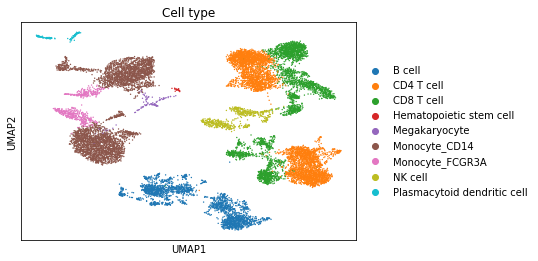

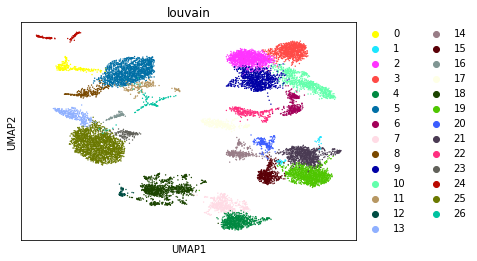

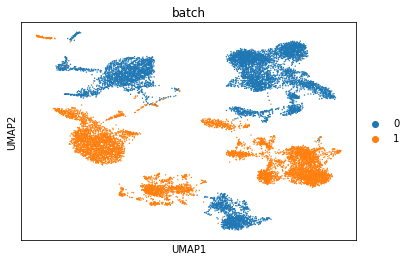

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [11]:
def createCountsDict(anndata):
    '''
    assumes the data has been grouped by cluster id and cell type. 
    
    return:
        cellCountsByClusterId: 
            a dictionary of form d['cellType']['cellType'] == count
            
        cellTypesInClusters:
            a dictionary of form d['clusterId']{'cell type1', 'cell type2'}
    
    arguments:
        pandasGroupedData:
            example : df.groupby(['louvain', 'Cell type'])['louvain'].count()
            
        keys:
            example: grouped.groups.keys()
    '''
    df = anndata.obs.loc[:,['louvain', 'Cell type']]
    grouped = df.groupby(['louvain', 'Cell type'])
    pandasGroupedData=grouped['louvain'].count()
    keys=grouped.groups.keys()
    
    cellCountsByClusterId = {}
    cellTypesInClusters = {}
    for tup in keys:
        clusterId,cellType = tup
        if cellType not in cellCountsByClusterId :
            cellCountsByClusterId[cellType] = {}

        cellCountsByClusterId[cellType][clusterId] = pandasGroupedData[tup]
        
        if clusterId not in cellTypesInClusters:
            cellTypesInClusters[clusterId]= set()
        
        cellTypesInClusters[clusterId].add(cellType)
        
    return cellCountsByClusterId, cellTypesInClusters

In [12]:
cellCountsByClusterId, cellTypesInClusters = createCountsDict(anndata)

In [13]:
def cellCount(df, cellType):
    rows = (df.loc[:,['Cell type']] == cellType)
    n = rows.sum()
    # n is a pandas series
    return n.values[0]

In [14]:
# TODO: AEDWIP: define a class to store results. NO MAGIC NUMBERS
K_CELLTYPE = 0
K_P_VALUE = 1
K_X = 2
K_M = 3
K_n = 4
K_N = 5

def annotationProbsForCluster(anndata, cellTypesInClusters, clusterId):
    '''
    aedwip: todo:
    
    arguments:
    
    returns a list of tuples of following form
        (cellType, p, x, M, n, N)
        p = p-value
        x = number of cells in cluster of cellType
        M = populations size
        n = number of cell types in population
        N = number of cells in the cluster
        
    '''
    ret = []
    df = anndata.obs.loc[:,['louvain', 'Cell type']]
    M = df.count()[0] # size of population
#     print("M:{}".format(M))

    cellTypes = cellTypesInClusters[clusterId]
    for cellType in cellTypes:
        # count the number of cells in the cluster
        rows = df['louvain'] == clusterId
        N = sum(rows)

        totalCount = cellCount(df, cellType)
        n = totalCount # number of cell types in populations

        randomVariable = stats.hypergeom(M, n, N)
        x = cellCountsByClusterId[cellType][clusterId]
        pValue = 1.0 - randomVariable.cdf(x)
        
        ret.append( (cellType, pValue, x, M, n, N) )
        
    return ret
          
ret = annotationProbsForCluster(anndata, cellTypesInClusters, clusterId='0')

# print("\n\n************\nret:\n{}".format(ret))

In [15]:
def bestAnnotation(anndata, cellTypesInClusters):
    '''
    uses hypergeometric distribution to best-matching cell type annotation 
    
    returns:
        dataframe with a row for each cluster. the columns are 'cell type' and probablity
    '''
    clusterIds = cellTypesInClusters.keys()
    retDF = pd.DataFrame()
    
    for clusterId in clusterIds:
        stats = annotationProbsForCluster(anndata, cellTypesInClusters, clusterId)

        best = min(stats, key=lambda tup : tup[K_P_VALUE])

        bestDF = pd.DataFrame( data={'clusterId':int(clusterId),
                                     'Cell type':best[K_CELLTYPE],
                                     'p-value':best[K_P_VALUE]}, 
                                index=[int(clusterId)] )
        retDF = retDF.append(bestDF)
    
    return retDF
        

In [16]:
retDF = bestAnnotation(anndata, cellTypesInClusters)  
retDF.sort_values(by=['clusterId'])

,clusterId,Cell type,p-value
0,0,Monocyte_CD14,0.000000e+00
1,1,CD8 T cell,1.191841e-09
2,2,CD4 T cell,0.000000e+00
3,3,CD8 T cell,2.882461e-11
4,4,B cell,0.000000e+00
5,5,Monocyte_CD14,0.000000e+00
6,6,CD8 T cell,7.912004e-12
7,7,B cell,0.000000e+00
8,8,Monocyte_FCGR3A,0.000000e+00
9,9,CD4 T cell,0.000000e+00


## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [26]:
def getCellsIdxForCluster(anndata, clusterId):
    '''
    returns a list of indices that can be use to select the cells in 
    the cluster. the indices are int values that correspond to the
    rows in the numpy array anndata.obsm['X_pca']
    
    assumes clustering algorithym was run and results stored in
    anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    numCells = anndata.obs['louvain'].size

    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterCells = louvainDF['louvain'] == clusterId
    ret = louvainDF.loc[clusterCells, ['npIdx']]
    return ret.values.flatten()
    
def testGetCellsIdxForCluster(anndata):
    ret = getCellsIdxForCluster(anndata,clusterId='9')
    print("TEST len(ret):{}".format(len(ret)))
    
testGetCellsIdxForCluster(anndata)

TEST len(ret):1011


In [27]:
def getGeneExpressionSignatureForCluster(anndata, clusterId):
    '''
    returns the centroid for cluster
    
    assumes:
        1) gene expression values stored in anndata.X
        
        2) clustering algorithym was run and results stored in
            anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    cellIndices = getCellsIdxForCluster(anndata ,clusterId)
    # pathways are in gene space not pca(50) space
    # anndata.obsm is a pandas data frame
    # data = anndata.obsm['X_pca'][cellIndices]
    # anndata.X is numpy array
    data = anndata.X[cellIndices, :]

    byColumns = 0
    return np.mean(data, axis=byColumns)

def testGetGeneExpressionSignatureForCluster(anndata):
    ret = getGeneExpressionSignatureForCluster(anndata, clusterId='9')
    # Sample data 
    # PCA 50
    #expFirst = np.array([-5.547451, 13.029236, -0.9483415, 
    #                    -5.8531246, -2.0250516])
    #expLast = np.array([-0.05719902, -0.16065401, 0.14730875, 
    #                    0.00936914, -0.06920523])
    
    # anndata.XC
    print("TEST ret[0:5]:\n{}".format(ret[0:5]))
    print("TEST ret[-5:]:\n{}".format(ret[-5:]))
    
testGetGeneExpressionSignatureForCluster(anndata)

TEST ret[0:5]:
[-0.1748246   0.09069756  0.5731959   0.8570365  -0.11152221]
TEST ret[-5:]:
[ 0.15200162 -0.05067453 -0.06716546 -0.90413594 -0.552749  ]


In [19]:
def calculateClusterSignatures(anndata):
    '''
    for each cluster calls getGeneExpressionSignatureForCluster()
    
    returns a dictionary. Key is the cluster id, value is its signature
    '''

    numCells = anndata.obs['louvain'].size
    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterSigs = {}
    for clusterId in pd.unique(louvainDF['louvain']) :
        sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
        clusterSigs[clusterId] = sig
    
    return clusterSigs

clusterSigs = calculateClusterSignatures(anndata)

In [20]:
def rankPathWaysForCluster(anndata, clusterSigs, clusterId):
    '''
    # to speed up testing do not run if results have already been calculated
    
    returns a tuple (cvsPath, preRes)
        if cvsPath exists preRes == None
    '''
    rnkDf = pd.DataFrame(data={'gene':anndata.var['GeneName-0'],
                               'score':clusterSigs[clusterId]})
    
    base = './gseapy.out/prerank_report_GO_Biological_Process_2018_clusterId-' 
    path = base + clusterId
    #print("path:{}".format(path))
    
    # path to output from previous run
    csvPath = path + "/" + 'gseapy.prerank.gene_sets.report.csv'
    #print("cvsPath:{}".format(csvPath))
    
    # to speed up debugging do not run if results have already been 
    # calculated
    ret = None
    exists = os.path.isfile(csvPath)
    if exists:
        # gseapy.gsea.Prerank
        # type(ret):<class 'gseapy.gsea.Prerank'>
        #ret.outdir = csvPath 
        ret = (csvPath, None)
    else:
        preRes = gp.prerank(rnk=rnkDf, 
                         gene_sets='GO_Biological_Process_2018',
                         processes=4,
                         permutation_num=100, # reduce number to speed up test
                         outdir=path,format='png')
        ret = (csvPath, preRes)
        
    #print("type(ret):{}".format(type(ret)))
    return ret

In [21]:
def rankPathWays(anndata, clusterSigs, topN=5):
    '''
    returns a panda dataframe with columns Term, nes, cluster id
        Term: pathway
        nes: normalized enrichment score
        cluster id: an integer
    '''
    retDF = pd.DataFrame()
    for clusterId in clusterSigs.keys():
        csvPath, preRes = rankPathWaysForCluster(anndata, 
                                         clusterSigs, 
                                         clusterId)
        df = pd.read_csv(csvPath)
        df2 = df.sort_values(by='nes', ascending=False)
        df3 = df2.iloc[0:topN, [0, 2]]
        numRows = df3.shape[0]
        cid = [int(clusterId) for j in range(numRows)]
        df3['cluster id'] = cid
        retDF = retDF.append(df3)
        
    retDF = retDF.sort_values(by='cluster id')
    return retDF  

In [22]:
%%time
retDF = rankPathWays(anndata, clusterSigs, topN=5)

CPU times: user 1.74 s, sys: 17.6 ms, total: 1.76 s
Wall time: 1.78 s


In [23]:
# https://stackoverflow.com/a/35693013/4586180
# display data frame with out index column
from IPython.display import display, HTML
display(HTML(retDF.to_html(index=False)))

Term,nes,cluster id
tumor necrosis factor-mediated signaling pathw...,1.703791,0
T cell activation (GO:0042110),1.649807,0
positive regulation of protein kinase B signal...,1.585081,0
regulation of immune response (GO:0050776),1.539449,0
regulation of protein kinase B signaling (GO:0...,1.795614,0
regulation of immune response (GO:0050776),1.386783,1
enzyme linked receptor protein signaling pathw...,2.055423,1
transmembrane receptor protein tyrosine kinase...,1.589282,1
"complement activation, classical pathway (GO:0...",1.408401,1
T cell activation (GO:0042110),2.351197,1
